# 02 Quick start with the analysis of the simulation data 


## Introduction

In this tutorial, we will go through the steps of building spatial RNA graphs for "unsupervised" spatial neighbourbood learning using graph neural network models. Here we focus on spatial transcriptomics data from imaging-based platforms which produce the list of detected transcripts with physical coordinates in the tissue space.

For the purpose of demonstration, we will analyse a synthetic dataset generated using the simulation module from [ficture](https://github.com/seqscope/ficture/). Briefly, transcripts from ten distinct cell types were simulated and arranged in three shapes in the 2D space. Two cell types have been placed randomly (scattered) across the space, and the remaining cells have been more restricted to a particular area. For more information regarding the simulation data please refer to [tutorial 01](./01_Prepare_inputs_simulation_data.ipynb). For downloading a copy of the data used in this tutorial, it is available on [Zenoto](https://zenodo.org/records/15550214).

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from torch_geometric.nn import radius_graph
from torch_geometric import seed_everything
import torch
import os.path as osp
import time
import torch.nn.functional as F
from torch_geometric.loader import LinkNeighborLoader,NeighborLoader
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import Data
import random 
from pathlib import Path
from torch_geometric.loader import DataLoader


In [4]:
## for reproduciable results
seed = 1024
random.seed(seed)  # python random seed
np.random.seed(seed)  # numpy random seed
torch.manual_seed(seed)  # pytorch random seed
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed_everything(seed)


## Apply GNN to learn spatial neighbourhoods of molecules in the tissue

### Building RNA-transcript spatial graphs 

We next construct a spatial graph for all the mRNA transcripts in the simulated dataset. In this graph, each node represents a transcript, we connect nodes when their physical distance is smaller than a `radius_r`, i.e., edges are added between transcripts that sit close (< `radius_r`)in the physical space. We initialize each node's input feature with the transcript's gene labels after one-hot-encoding transformation. The graph is stored as `torch_geometric.data.Data`. 



#### Required directory structure

We will use the `SpatialRNA` function for constructing the graph data from the input transcripts. `SpatialRNA` expects input files in a certain directory structure, for example, for `sample_x`, 
```console
./data_dir/sample_x/raw/sample_x.csv
```
,where `sample_x.csv` is the CSV file with list of detected transcripts (aftering removing non-gene transcripts, i.e., control probes).

Now run `SpatialRNA` for constructing the graph

For this simulated dataset, we have transcripts originating from 500 genes. It means the initial input feature vector for each transcript/node in the graph will be a vector of length 500.


In [5]:
gene_list = np.unique(pd.read_csv("../data/feature.tsv.gz",sep="\t").gene.values) ## find and substitute this with your  gene_panel information for your real data
gene_list[:10]  # show first 10 genes


array(['2310065F04Rik', '2610528A11Rik', '4931406C07Rik', 'AA467197',
       'Abcb11', 'Acaa1b', 'Acsm2', 'Acta1', 'Actc1', 'Actn2'],
      dtype=object)

In [6]:
x = torch.tensor(np.arange(gene_list.shape[0]))
one_hot_encoding = dict(zip(gene_list, F.one_hot(x, num_classes=gene_list.shape[0])))
#one_hot_encoding["Abcb11"]  # show one-hot encoding for gene Abcb11


tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

It means transcripts with gene label `Abcb11` are encoded with the vector shown above. However, for reducing storage and I/O we simply store the features of the nodes using integers, and we will convert integer numbers to one-hot-encoding vectors during model training and inference steps.

In [7]:
gene_int = dict(zip(gene_list, torch.tensor(np.arange(gene_list.shape[0])))) 
gene_int["Abcb11"]  # show integer encoding for gene Abcb11

tensor(4)

We next will use the x,y locations of the transcripts to build a radius-based graph using the `SpatialRNA` dataset constructor. The value of radius is essential, which determins the size of spatial aggregation (spatial smoothing). We use a radius of 3.0 for this tutorial. The simulation data is managable without tiling, for illustration we set the number of tiles to 2.



In [8]:
ls ../data/sim_sample/raw/

sim_sample.csv


In [23]:
from spatialrna import SpatialRNA
sample_name = "sim_sample"
dataset_dir = Path("../data/")
# Create the SpatialRNA object with the specified parameters    
data = SpatialRNA(
    root = dataset_dir / f'{sample_name}/' ,
    sample_name=sample_name,
    one_hot_encoding=gene_int,
    num_tiles = 2,
    dim_x = "X", # x coordinate column name in the CSV file
    dim_y = "Y", # y coordinate column name in the CSV file
    tile_by_dim="Y", # tile by dimension, can be "X" or "Y"
    process_mode="tile", # create tile graph, currently only one tile.
    load_type="tile", # load_type can be "blank", no data will be loaded; "graph", load tile graph; "subgraph", load the sampled subgraph.
    feature_col="gene", # feature column name in the CSV file
    force_reload=True,
    process_tile_ids=[0,1], ## Recursivly process first and the second tile. Can choose to only process one tile per process, and use slurm batch job to batch process. 
    num_neighbours=[-1,-1], # number of neighbours for each layer, -1 means all neighbours
    radius_r=3.0 # 
)


Processing...


Processing raw file  ../data/sim_sample/raw/sim_sample.csv
To create processed files  ['../data/sim_sample/processed/sim_sample_data_tile0.pt', '../data/sim_sample/processed/sim_sample_data_tile1.pt']
Raw data shape 557521
tile core area shape  (277967, 8)
left padding shape  0
right padding shape  6046
core area plus paddings, shape  (284013, 9)
tile core area shape  (279554, 8)
left padding shape  7428
right padding shape  0
core area plus paddings, shape  (286982, 9)
loading from file  ../data/sim_sample/processed/sim_sample_data_tile0.pt


Done!


We can inspect the generate radius graph data:

In [24]:
data = data[0]
data

Data(x=[284013], edge_index=[2, 23324208], trans_id=[284013], core_mask=[284013])

Data files were created in the processed dir 

```console
ls ../data/sim_sample/processed/
```

We now constructed the data object for GNN training, which consists of 

- `x`: contains the initial feature matrix for nodes in the graph; 
- `edge_index`: contains the list of edges in the format of a pair of nodes.

In an 'unsupervised'-training setting, true labels are not known and not used for training. In the case of training a GNN model for label (such as cell type) prediction, please check the [advanced use cases](./advanced_01_model_for_cell_type_prediction.ipynb).

In [25]:
data.x,data.edge_index


(tensor([ 54, 109, 293,  ..., 479, 374, 479]),
 tensor([[    81,    302,    170,  ..., 283976, 283980, 283990],
         [     0,      0,      0,  ..., 284012, 284012, 284012]]))

### Construct data loader 

In an 'unsupervise' training setting, model training is achieved by solving the edges (link) prediction task. Firstly, we build a training data loader which loads the specified number of graphs as one data batch. From the data batch, we further generate/sample mini-batches of graphs.

We first construct a `onDiskDataLoader` class that essentially records our generated .pt (graph object) files for our input samples tiles.



In [26]:
import spatialrna.spatialrna_ondisk as spod
## if you had prepared subgraphs.pt 
## in ../data/samplename/subgraph/samplename_subgraph_data_tile0.pt and would like to train over the subgraph, 
## you can change the pt_dir to "subgraph"
myod = spod.SpatialRNAOnDiskDataset(root = "../data/",pt_dir="processed")
myod.len()


Processing...
Done!


2

To inspect the graph data in `myod`, you can use myod.get, see more at [link](https://pytorch-geometric.readthedocs.io/en/2.4.0/generated/torch_geometric.data.OnDiskDataset.html)

In [27]:
## get the first 
myod.get(0)

Data(x=[284013], edge_index=[2, 23324208], trans_id=[284013], core_mask=[284013])

In [ ]:
# Uncomment if splitting the graph tiles in myod to Train and Validation.
# Split indices: 80% train, 20% validation
# 
# indices = list(range(len(myod)))
# train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
# train_idx[0:5], val_idx[0:5],len(train_idx),


In [35]:

# use the two tiles for training
train_idx = [0,1]
train_dataset = myod.index_select(train_idx)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
#val_loader   = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=2)


## Construct GNN model, GraphSAGE

Now we have prepared our DataLoader object. Next we construct a 2-hop GraphSAGE model with hidden channel size 50.

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
number_class = 500
model = GraphSAGE(
    number_class,
    hidden_channels=50,
    num_layers=2).to(device)

In [41]:
torch.cuda.is_available()

True

### Train the GraphSAGE model via link prediction

In [42]:
## use the train function 
import spatialrna.train_val as train_val

Training loss is constructed by predicting whether a pair of nodes should be linked (with an edge) based on the current latent representations produced by the model.

It is not necessary to train the model using all edgegs in the all the tile graphs, and we can sample a certain number of edges for training. In the code chunk below, we sample 50k edges per data batch (batch_size = 2 tiles as defined above) and assign them the positive labels (1). Correspondingly, we randomly construct the same number of negative edges by joining the starting nodes with a randomly sampled node in the data. 

We specify the number of neighbours to sample for a seed node as [20, 10],  which means 20 and 10 neighbours are sampled respectively at the first and the second hop in its neighbourhood.

In [44]:
### Run the training and testing process for 20 epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
from time import time
times = []
for epoch in range(1, 21):
    start = time()
    loss,acc = train_val.train(
                model=model,
                train_loader=train_loader,
                device=device,
                num_classes=number_class,
                optimizer=optimizer,
                num_neighbors=[20,10],
                num_train_edges=50000,
            verbose=False)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.3f}')
    times.append(time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")


Epoch: 001, Loss: 0.6812, Acc: 0.583
Epoch: 002, Loss: 0.5653, Acc: 0.737
Epoch: 003, Loss: 0.4896, Acc: 0.757
Epoch: 004, Loss: 0.4694, Acc: 0.783
Epoch: 005, Loss: 0.4595, Acc: 0.804
Epoch: 006, Loss: 0.4562, Acc: 0.820
Epoch: 007, Loss: 0.4498, Acc: 0.836
Epoch: 008, Loss: 0.4459, Acc: 0.840
Epoch: 009, Loss: 0.4424, Acc: 0.843
Epoch: 010, Loss: 0.4433, Acc: 0.847
Epoch: 011, Loss: 0.4408, Acc: 0.864
Epoch: 012, Loss: 0.4366, Acc: 0.885
Epoch: 013, Loss: 0.4342, Acc: 0.893
Epoch: 014, Loss: 0.4360, Acc: 0.897
Epoch: 015, Loss: 0.4325, Acc: 0.905
Epoch: 016, Loss: 0.4320, Acc: 0.912
Epoch: 017, Loss: 0.4336, Acc: 0.910
Epoch: 018, Loss: 0.4318, Acc: 0.912
Epoch: 019, Loss: 0.4317, Acc: 0.912
Epoch: 020, Loss: 0.4292, Acc: 0.914
Median time per epoch: 8.6095s


# Obtain embedding for each transcript for downstream analysis

Model parameters have now been trained. We feed the graph data to get the latent embeddings for all transcripts for downstream analysis. We can obtain the embedding for each tile graph using the inference function.


In [45]:
train_val.inference(
    model=model, 
    device=device,
    sample_name="sim_sample",                
    root="../data/sim_sample/",
    tile_id=[0,1],      
    num_classes=number_class,   
    num_neighbors=[20,10])

# subgraph_loader = NeighborLoader(
#                         data,
#                         #input_nodes=data.x,
#                         #num_neighbors=[-1],
#                         num_neighbors=[10,10],
#                         batch_size=1024,
#                         replace=False,
#                         shuffle=False,
#                         subgraph_type = "bidirectional")


/mnt/beegfs/mccarthy/general/backed_up/rlyu/Projects/spatialrna_dev0.2/spatialrna/spatialrna/train_val.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.loa

## Latent embeddings generated

In [46]:
ls "../data/sim_sample/embedding"

sim_sample_data_tile0input_tx_id.csv  sim_sample_data_tile1input_tx_id.csv
sim_sample_data_tile0.npy             sim_sample_data_tile1.npy


Paried with the .npy (storing the latent embedding for input transcripts), there is the *input_tx_id.csv file. It stores the row index id for input transcripts in the "../data/sim_sample/raw/sim_sample.csv" to ensure the transcript meta information matches with the latent embedding.

# Cluster the transcripts using the embedding matrix

SpatialRNA provides a helper function to run KMeans clustering (from sklearn package) on the embedding npy files for all tiles. We also show how to do fast (GPU-accelerated) clustering using PyCave library. See Case study [repo](https://gitlab.svi.edu.au/biocellgen-public/case_study_xenium_5k_panel/-/tree/spatialrna02?ref_type=heads) `./code/run_gmm.py`.


In [47]:
from spatialrna import run_kmeans

In [50]:
run_kmeans.run_kmeans(root="../data/",
                      sample_name_list =["sim_sample"],
                      downsample_to=None, # when the number of input transcripts are huge
                      downsample_seed=1024,
                      n_clusters=10,
                      split_file_per_sample=True,
                     verbose=False)

['../data/sim_sample/embedding/sim_sample_data_tile0.npy', '../data/sim_sample/embedding/sim_sample_data_tile1.npy']
['../data/sim_sample/embedding/sim_sample_data_tile0input_tx_id.csv', '../data/sim_sample/embedding/sim_sample_data_tile1input_tx_id.csv']


The clustering labels are saved in 


In [51]:
ls ../data/sim_sample/clusters/

sim_sample.10clusters.csv


# Plot results

In [10]:
from spatialrna import viz
import importlib
importlib.reload(viz)

<module 'spatialrna.viz' from '/mnt/beegfs/mccarthy/general/backed_up/rlyu/Projects/spatialrna_dev0.2/spatialrna/spatialrna/viz.py'>

We provided two visualisation function in SpatialRNA to demonstrate example ways of visualising the transcript clusters. We first gather the transcript meta information and the cluster labels for the sample we would like to plot using the `get_tx_plot_df` function.

In [11]:
tx_meta_with_clusters = viz.get_tx_plot_df(
    root="../data/",
    sample_name="sim_sample",
    n_clusters=10)

In [12]:
tx_meta_with_clusters

,X,Y,gene,Count,cell_id,cell_shape,tx_ids,cluster_labels
0,0.0,31.39,Bgn,1,98,rod,0,1
1,0.0,345.69,Cfh,1,758,rod,1,1
2,0.0,278.56,Dkk3,1,626,rod,2,1
3,0.0,317.52,Sparc,1,692,diamond,3,1
4,0.0,372.04,Rcn3,1,792,diamond,4,1
...,...,...,...,...,...,...,...,...
557516,500.0,458.91,Lyz2,1,957,rod,557516,5
557517,500.0,389.13,Gm94,1,857,circle,557517,3
557518,500.0,169.83,Krt6a,1,395,rod,557518,3
557519,500.0,37.70,S100a16,1,99,background,557519,3


In [13]:
?viz.plot_pixel

Signature:
viz.plot_pixel(
    tx_meta,
    pixel_size: float = 10,
    min_points: int = 5,
    x='X',
    y='Y',
    cluster_labels='cluster_labels',
    figsize=(8, 8),
    cmap=None,
    join_method='avg',
    background_color='white',
    output_path=None,
    **kwargs,
)
Docstring:
Pixelate points and color each pixel by either:
  - average RGB of all points ("avg"), or
  - major label color ("major").
Pixels with < min_points are set to background.
File:      /mnt/beegfs/mccarthy/general/backed_up/rlyu/Projects/spatialrna_dev0.2/spatialrna/spatialrna/viz.py
Type:      function

We can generate pixel images and specify the size of the pixel:

In [19]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080','#e6beff',
 '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
 '#000075', '#808080', '#ffffff', '#000000']
#len(colors)
customise_cmap_k15 = dict(zip([x for x in range(10)],colors))

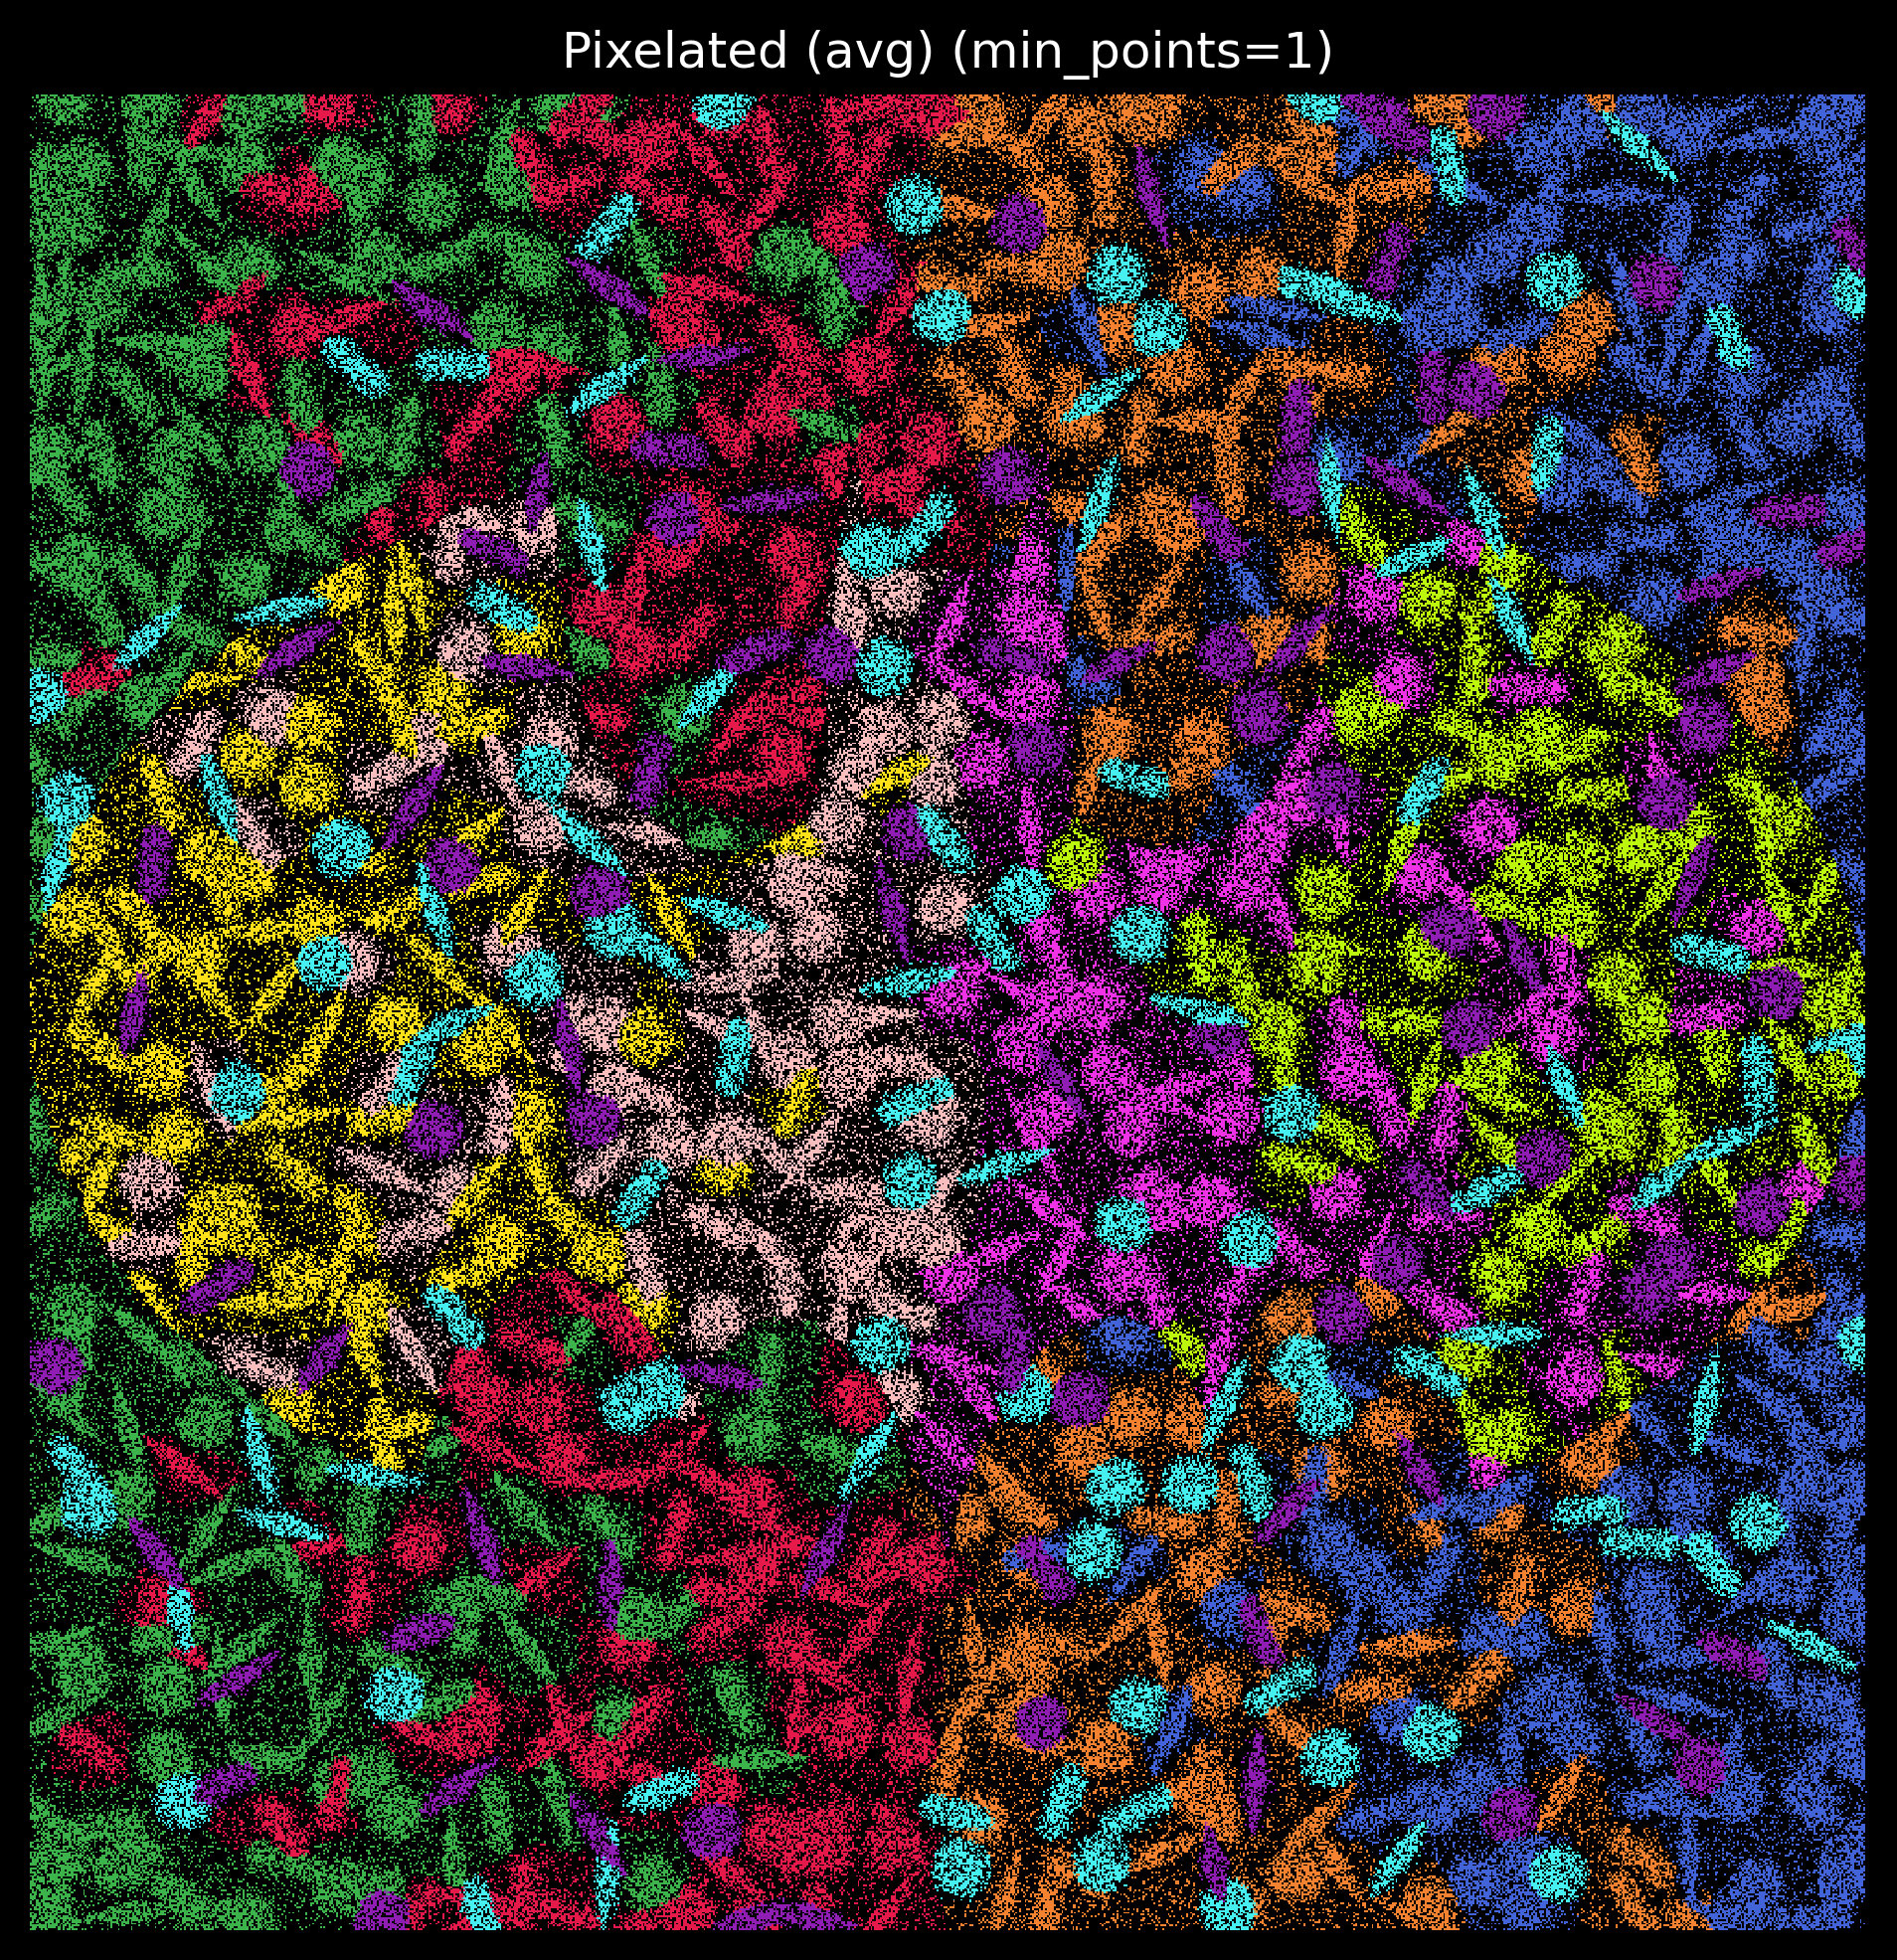

In [21]:
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'black'
plt.style.use('dark_background')
p_fig,ax = viz.plot_pixel(tx_meta = tx_meta_with_clusters,
                          pixel_size=0.5,
                          min_points=1,
                          cmap=customise_cmap_k15,
                          background_color="black",
                          join_method="avg",
                          dpi=300,figsize=(8,8))

# Match kmeans labels to simulated cell type labels

Since we have the ground-truth cell type labels, we can match the cluster ids to each cell type label, and quantify how well the clustering results capture the cell types.

In [35]:
groundtruth_label = pd.read_csv("../data/pixel_label.uniq.tsv.gz",sep="\t")

In [36]:
groundtruth_label.shape

(557521, 5)

In [37]:
tx_meta_with_clusters.shape

(557521, 8)

In [42]:
groundtruth_label["cluster_labels"] = tx_meta_with_clusters["cluster_labels"]

In [44]:
contingency_table = pd.crosstab(groundtruth_label.cell_label,groundtruth_label["cluster_labels"])

In [45]:
contingency_table

cluster_labels,0,1,2,3,4,5,6,7,8,9
cell_label,,,,,,,,,,
Kupffer_cell,100,267,99,285,266,47205,338,140,120,165
cardiac_muscle_cell,74,52,378,0,0,322,875,23,0,38549
cell_of_skeletal_muscle,0,0,0,36,40,353,530,253,38620,0
endothelial_cell,52,1,0,597,61740,936,1580,64,27,0
epithelial_cell_of_proximal_tubule,65301,1061,20,0,64,685,837,6,0,57
fibroblast,924,76076,79,0,0,704,862,3,0,44
granulocyte,98,103,91,179,230,90,55566,137,94,181
hepatocyte,31,61,40540,0,0,438,631,0,0,610
immature_NK_T_cell,14,0,0,20,97,625,543,41126,321,60


In [46]:
long_format = contingency_table.stack().reset_index()
long_format.columns = ['cell_labels', 'kmeans', 'Count']
long_format


,cell_labels,kmeans,Count
0,Kupffer_cell,0,100
1,Kupffer_cell,1,267
2,Kupffer_cell,2,99
3,Kupffer_cell,3,285
4,Kupffer_cell,4,266
...,...,...,...
95,keratinocyte,5,780
96,keratinocyte,6,1063
97,keratinocyte,7,82
98,keratinocyte,8,44


In [47]:
long_format['Proportion'] = long_format.groupby('cell_labels')['Count'].transform(lambda x: x / x.sum())
long_format


,cell_labels,kmeans,Count,Proportion
0,Kupffer_cell,0,100,0.002041
1,Kupffer_cell,1,267,0.005451
2,Kupffer_cell,2,99,0.002021
3,Kupffer_cell,3,285,0.005818
4,Kupffer_cell,4,266,0.005430
...,...,...,...,...
95,keratinocyte,5,780,0.010424
96,keratinocyte,6,1063,0.014206
97,keratinocyte,7,82,0.001096
98,keratinocyte,8,44,0.000588


In [48]:
sorted_pairs = long_format.sort_values(by='Proportion', ascending=False)


In [49]:
match_pair = long_format.iloc[long_format.groupby('cell_labels')['Proportion'].idxmax()]


The kmeans cluster labels are mapped to the groundtruth labels, for example kmeans cluster 5 corresponds to cell type kupffer_cell, and cluster 6 correspons to celltype granulocytes.

In [50]:
match_pair


,cell_labels,kmeans,Count,Proportion
5,Kupffer_cell,5,47205,0.963662
19,cardiac_muscle_cell,9,38549,0.957192
28,cell_of_skeletal_muscle,8,38620,0.969572
34,endothelial_cell,4,61740,0.949890
40,epithelial_cell_of_proximal_tubule,0,65301,0.959871
51,fibroblast,1,76076,0.966756
66,granulocyte,6,55566,0.978809
72,hepatocyte,2,40540,0.958143
87,immature_NK_T_cell,7,41126,0.960753
93,keratinocyte,3,72075,0.963248


In [56]:
match_pair_dict = dict(zip(match_pair.kmeans.astype(str) ,match_pair.cell_labels))
match_pair_dict


{'5': 'Kupffer_cell',
 '9': 'cardiac_muscle_cell',
 '8': 'cell_of_skeletal_muscle',
 '4': 'endothelial_cell',
 '0': 'epithelial_cell_of_proximal_tubule',
 '1': 'fibroblast',
 '6': 'granulocyte',
 '2': 'hepatocyte',
 '7': 'immature_NK_T_cell',
 '3': 'keratinocyte'}

In [59]:
kmeans_cell_label = [match_pair_dict[str(x)] for x in groundtruth_label["cluster_labels"]]

In [63]:
#Using the same color coding as before 
## specify color maps
ground_truth_rgb = pd.read_csv("../data/model.rgb.tsv", sep="\t")
ground_truth_rgb

c_array = np.array(ground_truth_rgb[["R","G","B"]])
color_m = dict(zip(ground_truth_rgb.cell_label,range(0,10)))
color_m

{'Kupffer_cell': 0,
 'granulocyte': 1,
 'fibroblast': 2,
 'epithelial_cell_of_proximal_tubule': 3,
 'endothelial_cell': 4,
 'keratinocyte': 5,
 'hepatocyte': 6,
 'cardiac_muscle_cell': 7,
 'immature_NK_T_cell': 8,
 'cell_of_skeletal_muscle': 9}

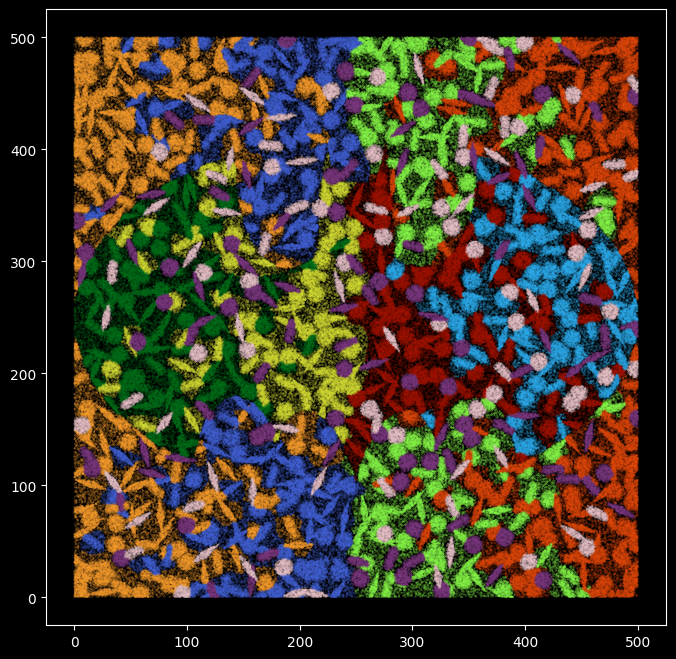

In [67]:
plt.figure(figsize=(8,8))
plt.rcParams['figure.facecolor'] = 'black'
plt.style.use('dark_background')

plt.scatter(
    x = groundtruth_label.X,
    y = groundtruth_label.Y,
    s=0.01,
    c=[c_array[color_m[x]] for x in kmeans_cell_label],alpha=1)


# Quantify the consistency between kmeans labels and groundtruth cell type labels  

In [69]:
np.array([kmeans_cell_label == groundtruth_label.cell_label]).sum()/groundtruth_label.shape[0]


np.float64(0.9628300996733755)

96% of the transcripts were assigned with the correct cell type labels.

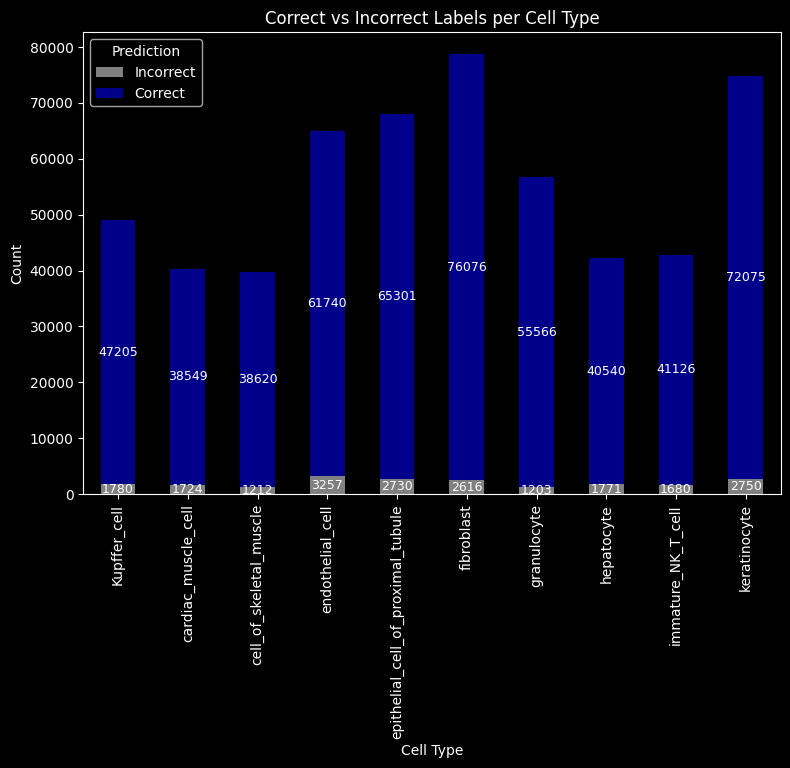

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assume these exist
# kmeans_cell_label: np.array or pd.Series
# groundtruth_label.cell_label: np.array or pd.Series

pred = np.array(kmeans_cell_label)
true = np.array(groundtruth_label.cell_label)

# put into DataFrame for grouping
df = pd.DataFrame({"true": true, "pred": pred})

# compute correct/incorrect per cell type
df["correct"] = df["true"] == df["pred"]
summary = df.groupby("true")["correct"].value_counts().unstack(fill_value=0)

# rename columns for clarity
summary = summary.rename(columns={True: "Correct", False: "Incorrect"})

# plot
ax = summary.plot(kind="bar", stacked=True, figsize=(9, 6),
                  color={"Correct": "darkblue", "Incorrect": "grey"})

ax.set_ylabel("Count")
ax.set_xlabel("Cell Type")
ax.set_title("Correct vs Incorrect Labels per Cell Type")
ax.legend(title="Prediction")

# annotate bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}",
                    (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                    ha="center", va="center", fontsize=9, color="white")

plt.show()


In [70]:
groundtruth_label["kmeans"] = kmeans_cell_label
#groundtruth_label.to_csv("../data/kmeans_out_dmax3.csv")

### Highlight the transcripts with inconsistent cell type labels

We now visualize the inconsistent transcripts, and we can see that those are likely to be from the outer layer (background) of a cell.

In [79]:
from itertools import compress

wrong_p = kmeans_cell_label != groundtruth_label.cell_label
pd.DataFrame(list(compress(kmeans_cell_label,wrong_p))).astype("category").value_counts()


0                                 
granulocyte                           7259
Kupffer_cell                          4933
fibroblast                            1545
endothelial_cell                      1477
epithelial_cell_of_proximal_tubule    1294
cardiac_muscle_cell                   1117
keratinocyte                          1117
immature_NK_T_cell                     708
hepatocyte                             667
cell_of_skeletal_muscle                606
Name: count, dtype: int64

## Highlight in-consistent transcripts
Transcripts that have been correctly classified are colored with grey, the inconsistent transcripts are highlighted and colored by groundtruth transcript labels.

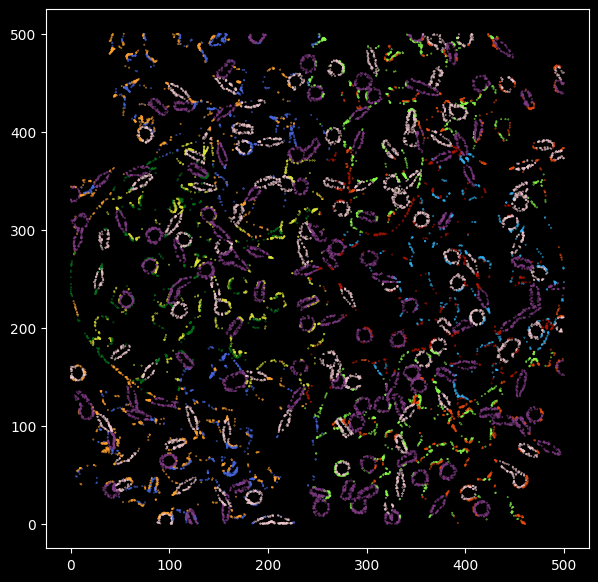

In [81]:
# wrong_p = kmeans_cell_label != true_label.cell_label
plt.figure(figsize=(7,7))
plt.rcParams['figure.facecolor'] = 'black'

plt.scatter(y=groundtruth_label.Y[wrong_p],x=groundtruth_label.X[wrong_p],s=0.1,
            c=[c_array[color_m[x]] for x in list(compress(kmeans_cell_label,wrong_p))],alpha=1)


In [82]:
boolean_vector = pd.Series(wrong_p)

# Map True to 0.5 and False to 1
numeric_vector = boolean_vector.map({True: 1, False: 0.1})


In [83]:
c_map = [c_array[color_m[x]] for x in groundtruth_label.cell_label]
#pd.Series(wrong_p)


In [84]:
cmap_m = np.stack(c_map)
cmap_m[~wrong_p,:] = 0.60
cmap_m

array([[0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6],
       ...,
       [0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6],
       [0.6, 0.6, 0.6]], shape=(557521, 3))

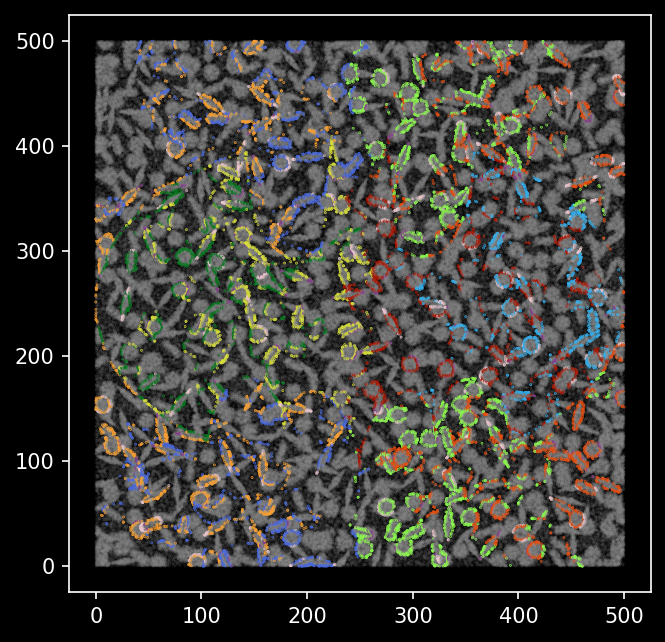

In [86]:
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['figure.dpi'] = '150'

plt.figure(figsize=(5,5))

# wrong_p = kmeans_cell_label != true_label.cell_label
plt.scatter(x=groundtruth_label.X,y=groundtruth_label.Y,s=0.1,
            c=cmap_m, alpha=numeric_vector)


We see the transcripts that were classified differently from the groundtruth cell type labels are mostly outlining the boundaries of cells. 


## ARI score

We can calculate the ARI score between our clusters derived based on latent embeddings and the ground-truth cell labels.

In [90]:
from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(groundtruth_label.cell_label, groundtruth_label.kmeans)
ari_score

0.9198942906061998

### Put together

(np.float64(-25.0), np.float64(525.0), np.float64(-25.0), np.float64(525.0))

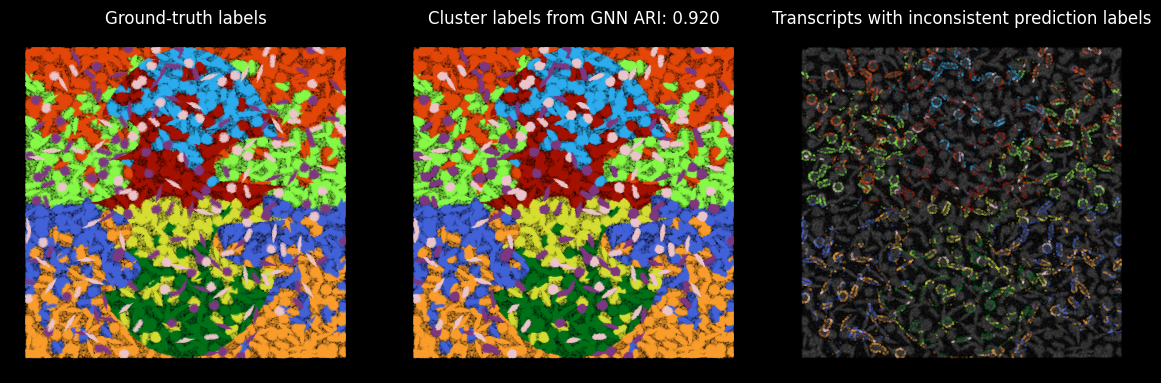

In [93]:
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['figure.dpi'] = '100'

fig,axes = plt.subplots(1,3,figsize=(12,4),sharey=True)
fig.tight_layout(h_pad=0.5)

axes[0].scatter(y = groundtruth_label.X,x = groundtruth_label.Y, s=0.01, c=[c_array[color_m[x]] for x in groundtruth_label.cell_label],alpha=1)
axes[0].set_title('Ground-truth labels')

axes[1].scatter(y=groundtruth_label.X,x=groundtruth_label.Y,s=0.01,c=[c_array[color_m[x]] for x in groundtruth_label.kmeans],alpha=1)
axes[1].set_title(f'Cluster labels from GNN ARI: {ari_score:.3f}')

axes[2].scatter(y=groundtruth_label.X,x=groundtruth_label.Y,s=0.01,c=cmap_m,alpha=numeric_vector)
axes[2].set_title('Transcripts with inconsistent prediction labels from groundtruth')

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
